In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import nltk
import string
import os
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn import ensemble
import scikitplot as skplt

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, models


In [2]:
sys.version

'3.7.5 (default, Apr 19 2020, 20:18:17) \n[GCC 9.2.1 20191008]'

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.test.is_gpu_available(cuda_only=True)

True

In [5]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [9]:
train["is_toxic"] = train.apply(
    lambda x: x.toxic or x.severe_toxic or x.obscene or x.threat or x.insult or x.identity_hate, axis=1
)

train = train.drop(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], axis=1)

In [10]:
train.head()

,id,comment_text,is_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


## Data Cleaning

In [11]:
# https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76

stop_words = nltk.corpus.stopwords.words("english")

def clean_text(x):
    x = x.lower()
    x = x.replace("\n", " ")
    x = x.replace("\t", " ")
    x = x.replace("'", "")
    x = x.replace('"', "")
    x = re.sub('[%s]' % re.escape(string.punctuation), "", x)
    x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'@\S+', ' ', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    return x

train["comment_text"] = train["comment_text"].apply(lambda x: clean_text(x))

KeyboardInterrupt: 

In [ ]:
train.head()

In [ ]:
#vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,1), max_features=1000)
vectorizer = CountVectorizer(analyzer='word', max_features=1000)
vectorized_X = vectorizer.fit_transform(train["comment_text"])

In [ ]:
# with open("11_19_20.vectorizer", "wb") as out:
#     pickle.dump(vectorizer, out)

In [ ]:
X = vectorized_X.toarray()
y = train["is_toxic"].to_numpy()

print(X.shape)
print(y.shape)

print(X[0])
print(y[0])

## Model

In [ ]:
model = models.Sequential([
    layers.Dense(1024, input_shape=(X.shape[1],)),
    layers.Dropout(0.3),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(1024),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(1024),
    layers.Activation('relu'),
    layers.Dense(1),
    layers.Activation('sigmoid')
])

adagrad = optimizers.Adagrad()
adam = optimizers.Adam()

model.compile(optimizer=adam,
              loss="binary_crossentropy",
              metrics=['accuracy'])

fit = model.fit(X, y, epochs=6, batch_size=64, verbose=True, validation_split=0.1)

In [ ]:
model.save("../11_19_20_model.h5", include_optimizer=False)

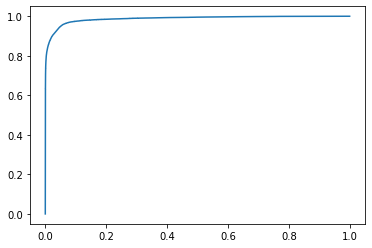

In [255]:
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y, model.predict(X))

plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## Test model on Twitch data

In [256]:
sys.path.append("..")
from chat_file import ChannelFile

messages = []
labels = []

labeled_message_file = ChannelFile("../hand_labeled.json", custom_json=True)

while True:
    message = labeled_message_file.next()
    if not message:
        break
        
    messages.append(message)
    labels.append(1 if message.toxicity == "negative" else 0)
    
print(messages[:5])
print(labels[:5])

[<chat_message.ChatMessage object at 0x7efedea3a510>, <chat_message.ChatMessage object at 0x7efed7610a50>, <chat_message.ChatMessage object at 0x7efed71e8390>, <chat_message.ChatMessage object at 0x7efc72470bd0>, <chat_message.ChatMessage object at 0x7efc72468910>]
[0, 0, 0, 0, 0]


0.6156605397111727


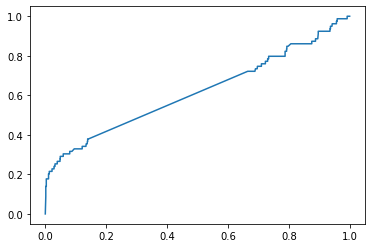

In [257]:
cleaned_message_content = [clean_text(message.content) for message in messages]
messages_X = vectorizer.transform(cleaned_message_content).toarray()

labels = np.array(labels)

predictions = model.predict(messages_X).flatten()

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(labels, predictions)

auc = metrics.roc_auc_score(labels, predictions)
print(auc)

plt.plot(false_positive_rate, true_positive_rate)
plt.show()

[[1130   91]
 [  57   22]]
0.8861538461538462


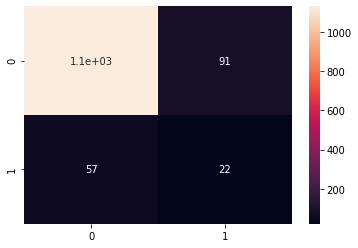

In [204]:
prediction_classes = [1 if prediction > 0.25 else 0 for prediction in predictions]

confusion_matrix = metrics.confusion_matrix(labels, prediction_classes)
print(confusion_matrix)

accuracy = metrics.accuracy_score(labels, prediction_classes)
print(accuracy)

sns.heatmap(confusion_matrix, annot=True)

## Compare NN model to VADER score

0.6981619133517868


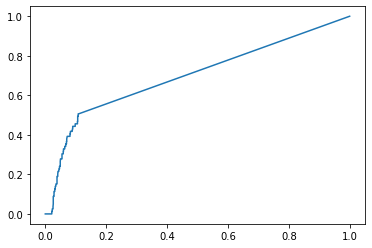

In [186]:
# vader_predictions = [message.vader_score["compound"] for message in messages]
# vader_predictions = [max(0, -1 * score) for score in vader_predictions]
vader_predictions = [message.vader_score["neg"] for message in messages]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(labels, vader_predictions)

auc = metrics.roc_auc_score(labels, vader_predictions)
print(auc)

plt.plot(false_positive_rate, true_positive_rate)
plt.show()

[[1131   90]
 [  48   31]]
0.8938461538461538


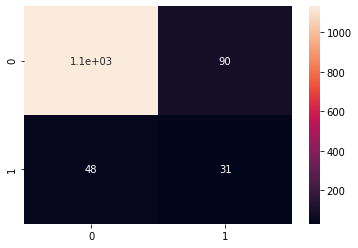

In [201]:
encoded_vader_predictions = [1 if vader_prediction > 0.3 else 0 for vader_prediction in vader_predictions]

confusion_matrix = metrics.confusion_matrix(labels, encoded_vader_predictions)
print(confusion_matrix)

accuracy = metrics.accuracy_score(labels, encoded_vader_predictions)
print(accuracy)

sns.heatmap(confusion_matrix, annot=True)

## Combined

0.25
0.7501580982593642


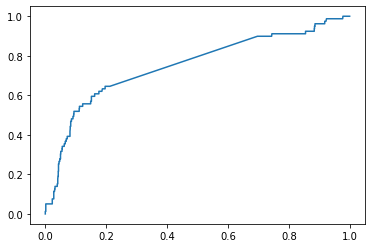

In [236]:
best_weight = 0
best_auc = 0
for weight in np.arange(0, 1, 0.05):
    scores = [(x1 * weight + x2 * (1 - weight)) / 2
          for x1, x2 in zip(predictions, vader_predictions)]
    auc = metrics.roc_auc_score(labels, scores)
    if auc > best_auc:
        best_auc = auc
        best_weight = weight

scores = [(x1 * best_weight + x2 * (1 - best_weight)) / 2
          for x1, x2 in zip(prediction_probabilities, vader_predictions)]
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(labels, scores)

print(best_weight)
print(best_auc)

plt.plot(false_positive_rate, true_positive_rate)
plt.show()

[[1149   72]
 [  52   27]]
0.9046153846153846


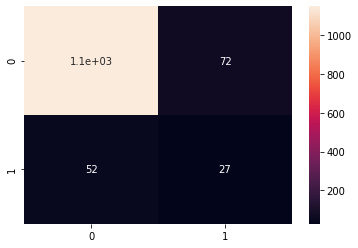

In [237]:
threshold = 0.19
classes = [1 if score > threshold else 0 for score in scores]

confusion_matrix = metrics.confusion_matrix(labels, classes)
print(confusion_matrix)

accuracy = metrics.accuracy_score(labels, classes)
print(accuracy)

sns.heatmap(confusion_matrix, annot=True)